# Setup and loading of data

In [ ]:
!pip install plotnine
# !python -m spacy download en_core_web_lg # Does not work in google colab

In [ ]:
import spacy.cli
spacy.cli.download("en_core_web_lg")
import spacy
nlp = spacy.load('en_core_web_lg', disable=["tagger", "parser", "ner", "textcat"])

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np


from plotnine import *
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer
from sklearn.metrics import classification_report
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import TfidfVectorizer
from statistics import mean, median
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
import random


%matplotlib inline

In [ ]:
appInfoSource = '/content/drive/MyDrive/Skolan/TDDE16/project/Shopify-app-store-2021-01-06/apps.csv'
reviewsTrueSource = '/content/drive/MyDrive/Skolan/TDDE16/project/Shopify-app-store-2021-01-06/truth_set_unordered_labeled_size100_FULL_V1.csv'
keyBenefitsSource = '/content/drive/MyDrive/Skolan/TDDE16/project/Shopify-app-store-2021-01-06/key_benefits.csv'
appInfodf = pd.read_csv(appInfoSource, encoding='utf8')
reviewsTruedf = pd.read_csv(reviewsTrueSource, encoding='utf8')
keyBenefitsdf = pd.read_csv(keyBenefitsSource, encoding='utf8')

In [ ]:
def lines():
  print("\n---------------\n")

# This function is used to find the name for an app given its UUID.
# It is needed for crossreferencing
def appName(uuid):
  retval = appInfodf.loc[appInfodf.loc[:,"id"] == uuid,"title"].reset_index(drop = True) 
  return retval

# Given an UUID this function will return all "key benefits" listed for that app.
def app(uuid):
  retval = appInfodf.loc[appInfodf.loc[:,"id"] == uuid].reset_index(drop = True) 
  return retval

# Given an UUID this function will return all "key benefits" listed for that app.
def keyBen(uuid):
  retval = keyBenefitsdf.loc[keyBenefitsdf.loc[:,"app_id"] == uuid].reset_index(drop = True) 
  return retval

# Given an UUID this function will return all reviews listed for that app.
def getReviews(uuid):
  retval = reviewsdf.loc[reviewsdf.loc[:,"app_id"] == uuid].reset_index(drop = True)
  return retval  

In [ ]:
ids = [i for i in reviewsTruedf["app_id"].unique()]
appInfodf = appInfodf[appInfodf["id"].isin(ids)].reset_index(drop=True)
appInfodf

,id,url,title,developer,developer_link,icon,rating,reviews_count,description_raw,description,tagline,pricing_hint
0,94e77128-9474-4076-b4a1-2ac6b880c8f3,https://apps.shopify.com/eu-cookie-bar,EU Cookie Bar GDPR ‑ 100% FREE,Booster Apps,https://apps.shopify.com/partners/booster-apps,https://apps.shopifycdn.com/listing_images/56e...,4.3,3279,"<div class=""block app-listing__detailed-descri...",Instant cookie compliance with EU law in one c...,Provide a cookie banner to EU customers. GDPR ...,NaN
1,4ee3c37d-7ad9-4a98-83d0-7b3ff8cf6cfb,https://apps.shopify.com/swell,Swell Loyalty & Rewards,Swell Rewards,https://apps.shopify.com/partners/swell-rewards,https://apps.shopifycdn.com/listing_images/f69...,4.7,2133,"<div class=""block app-listing__detailed-descri...",Yotpo Loyalty & Referrals (formerly Swell Rewa...,"Loyalty, Referrals & Rewards by Swell (a Yotpo...",NaN
2,d4d7e4ca-d939-4e8a-857c-37dc62db7c22,https://apps.shopify.com/omnisend,Omnisend Email Marketing,Omnisend,https://apps.shopify.com/partners/omnisend,https://apps.shopifycdn.com/listing_images/9b0...,4.7,3697,"<div class=""block app-listing__detailed-descri...",Join fellow Shopify merchants that have truste...,The All-In-One Marketing Automation Platform w...,NaN
3,2264513f-8aa0-4836-92b6-362976e76b54,https://apps.shopify.com/mailchimp-forms,MailChimp Forms by MailMunch,MailMunch,https://apps.shopify.com/partners/mailmunch,https://apps.shopifycdn.com/listing_images/3fc...,4.5,1289,"<div class=""block app-listing__detailed-descri...",Collecting emails from your store visitors is ...,Grow your MailChimp list with exit intent popu...,NaN
4,c769a28f-379a-4346-8871-915b558a099d,https://apps.shopify.com/printful,Printful: Print‑on‑Demand,Printful,https://apps.shopify.com/partners/jansons,https://apps.shopifycdn.com/listing_images/3dd...,4.4,3025,"<div class=""block app-listing__detailed-descri...",Partner with the #1 print-on-demand drop shipp...,Top rated print-on-demand drop shipping & ware...,NaN


In [ ]:
# Extracting columns of interest
reviewsTruedf = reviewsTruedf[["app_id","rating","body","mentions_kb"]]
appInfodf = appInfodf[["id","title","reviews_count","description","tagline"]]
reviewsTruedf = reviewsTruedf[reviewsTruedf["mentions_kb"] != 401]

for index, row in reviewsTruedf.iterrows():
  reviewsTruedf["mentions_kb"][index] = (reviewsTruedf["mentions_kb"][index] == 1)

tmpid = 95
print(reviewsTruedf.loc[tmpid]["app_id"])
print(reviewsTruedf.loc[tmpid]["body"])
print(reviewsTruedf.loc[tmpid]["mentions_kb"])


2264513f-8aa0-4836-92b6-362976e76b54
I am not sure why they haven't gotten back to me after opening multiple support tickets. The software seems great, but the popup form isn't displayed on my site, even when I try via Incognito browser. I will update the review if I hear back from them!
They replied very quickly. Form works well :)
True


In [ ]:
tableappInfodf = appInfodf[["id","title","reviews_count"]]
tableappInfodf.to_latex(index=False, caption="\label{tab:apps_choosen}The 5 apps choosen for project.")

In [ ]:
tmpdf = pd.DataFrame()

for id in ids:
  tmpdf = pd.concat([tmpdf,keyBen(id)]).reset_index(drop=True)


for index, row in tmpdf.iterrows():
  #print(appName(row["app_id"])[0])
  #print(tmpdf.loc[index,"app_id"])
  tmpdf.loc[index,"app_id"] = (appName(row["app_id"])[0])[0:10] + "..."

tmpdf.to_latex(caption="\label{tab:key_benefits}The key benefits of choosen apps", index=False)

# Displaying data composition

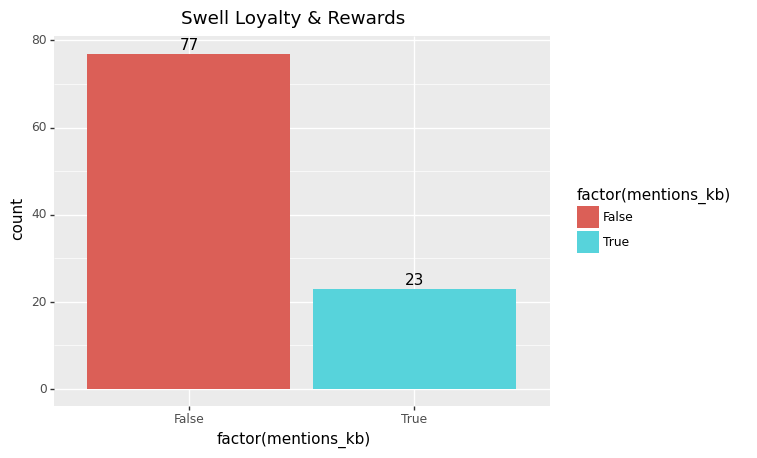

<ggplot: (8727590963583)>


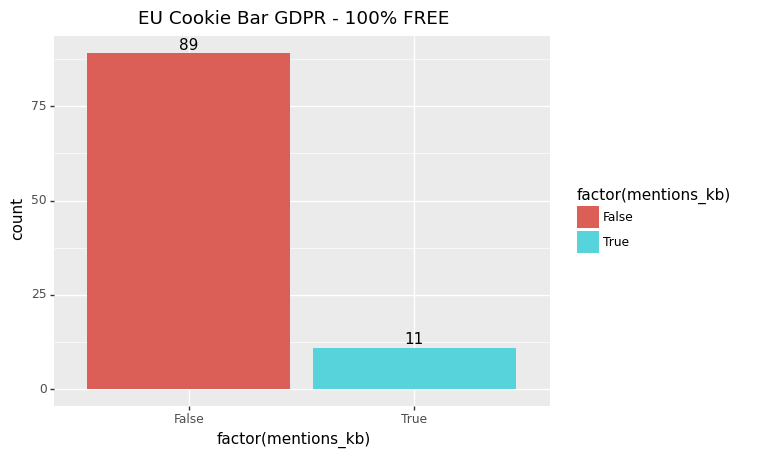

<ggplot: (-9223363309285510456)>


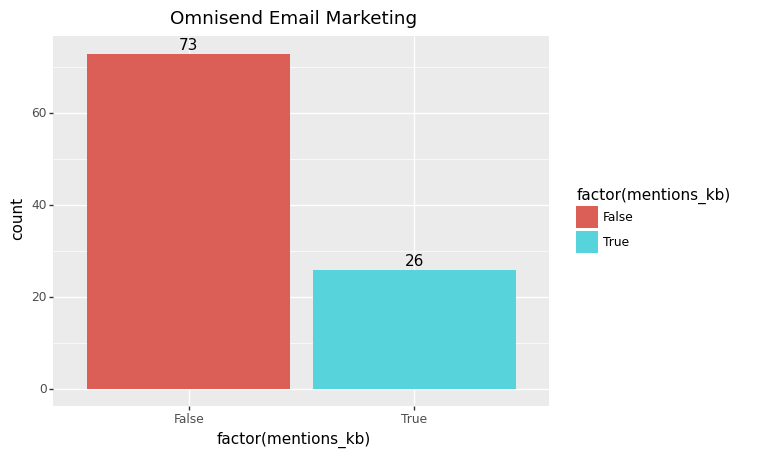

<ggplot: (8727569060700)>


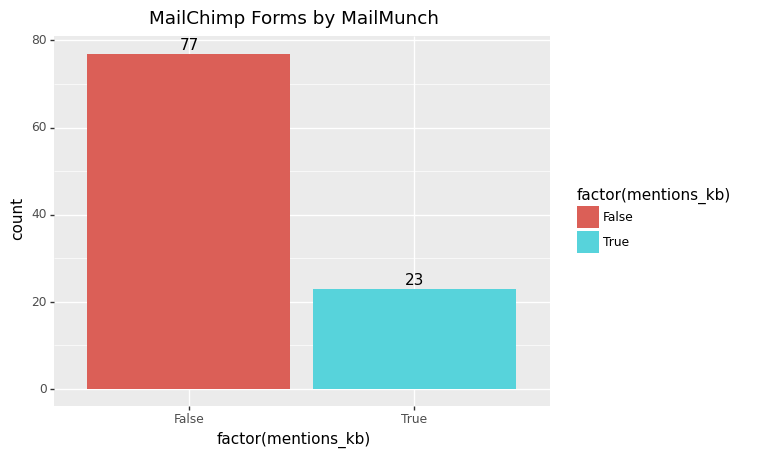

<ggplot: (-9223363309285228263)>


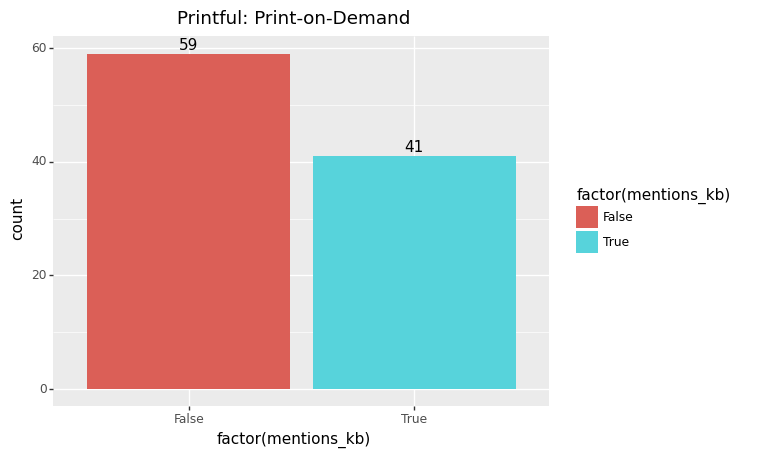

<ggplot: (-9223363309239550064)>


In [ ]:
# Bar chart using ggplot

for id in ids:
  curid = id
  currev_df = reviewsTruedf[reviewsTruedf["app_id"]==curid].reset_index(drop=True)
  print(ggplot(currev_df, aes('factor(mentions_kb)', fill='factor(mentions_kb)'))
  + geom_bar()
  + geom_text(
     aes(label='stat(count)'),
     stat='count',
     nudge_y=0.125,
     va='bottom'
     )
  + labs(title=appName(id)[0])
  )

  p = (
      ggplot(currev_df, aes('factor(mentions_kb)', fill='factor(mentions_kb)'))
  + geom_bar()
  + geom_text(
     aes(label='stat(count)'),
     stat='count',
     nudge_y=0.125,
     va='bottom'
     )
  + labs(title=appName(id)[0])
  )

  ggsave(plot = p, filename = str(id) + '.png', path = '/content/drive/MyDrive/Skolan/TDDE16/project/Shopify-app-store-2021-01-06/')

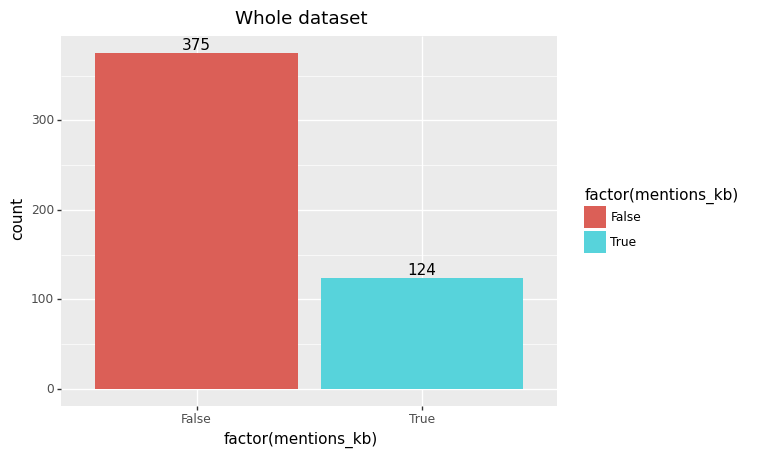

<ggplot: (8727615445722)>


In [ ]:
print(ggplot(reviewsTruedf, aes('factor(mentions_kb)', fill='factor(mentions_kb)'))
  + geom_bar()
  + geom_text(
     aes(label='stat(count)'),
     stat='count',
     nudge_y=0.125,
     va='bottom'
     )
  + labs(title="Whole dataset")
  )

p = (ggplot(reviewsTruedf, aes('factor(mentions_kb)', fill='factor(mentions_kb)'))
  + geom_bar()
  + geom_text(
     aes(label='stat(count)'),
     stat='count',
     nudge_y=0.125,
     va='bottom'
     )
  + labs(title="Whole dataset")
  )

ggsave(plot = p, filename = 'whole_set.png', path = '/content/drive/MyDrive/Skolan/TDDE16/project/Shopify-app-store-2021-01-06/')

In [ ]:
reviewsTruedf.groupby(by='mentions_kb').count()
reviewsTruedf

,app_id,rating,body,mentions_kb
0,4ee3c37d-7ad9-4a98-83d0-7b3ff8cf6cfb,5.0,Very easy to setup and customize. Looking forw...,True
1,4ee3c37d-7ad9-4a98-83d0-7b3ff8cf6cfb,5.0,So Excited for this Feature!! :D This is what ...,True
2,94e77128-9474-4076-b4a1-2ac6b880c8f3,5.0,Very good regarding the use that I have of it....,False
3,4ee3c37d-7ad9-4a98-83d0-7b3ff8cf6cfb,5.0,I've just started using the app on my store so...,False
4,4ee3c37d-7ad9-4a98-83d0-7b3ff8cf6cfb,5.0,Great app. Fairly easy to setup and activate....,True
...,...,...,...,...
495,c769a28f-379a-4346-8871-915b558a099d,4.0,COOL. Just missing mannequins displaying the c...,False
496,4ee3c37d-7ad9-4a98-83d0-7b3ff8cf6cfb,5.0,"Easy to use, Easy to manage, and my customers ...",False
497,c769a28f-379a-4346-8871-915b558a099d,5.0,One of the greatest programs out there I tried...,True
498,4ee3c37d-7ad9-4a98-83d0-7b3ff8cf6cfb,5.0,excellent rewards program! Simple to use! www....,False


# Starting to work on data analysis and classification

## Defining function for splitting data into training and testing

In [ ]:
# Funtion for splitting data


def make_test_train_split(df, test_size):
  df = df.reset_index(drop=True)
  len_df = len(df)
  selection = random.sample(range(0,len_df),k=int(np.ceil(test_size * len_df)))
  test = df.loc[df.index.isin(selection)]
  train = df.loc[~df.index.isin(selection)]
  # print("test {}, train {}, sum {}".format(len(test),len(train), len(test)+len(train)))
  return (test,train)

def create_test_train(df, test_size = 0.33, random_state = None):
  col_names = [col for col in df]
  if not random_state == None:
    # print("\n---Setting seed---\n")
    random.seed(a=random_state, version=2)
  train = pd.DataFrame(columns=col_names)
  test = pd.DataFrame(columns=col_names)

  for appid in df["app_id"].unique():
    # print(appid)
    cur_rev = df[df["app_id"] == appid]
    df_true = cur_rev[cur_rev["mentions_kb"] == True]
    df_false = cur_rev[cur_rev["mentions_kb"] == False]
    test_true, train_true = make_test_train_split(df_true, test_size)
    test_false, train_false = make_test_train_split(df_false, test_size)
    test = pd.concat([test, test_true,test_false])
    train = pd.concat([train, train_true, train_false])
    # Shuffeling the final dfs
    test = test.sample(frac=1, random_state=random_state).reset_index(drop=True)
    train = train.sample(frac=1, random_state=random_state).reset_index(drop=True)
    # print("-------------------------------------")

  return (test,train)

## Using code from Lab 1

**idea:** Start by vectorizing the key benefits with tfid. Then fit each review and based on `return_distance` being closer than X to key benefit vector return this value.

### Defining preprocess function

In [ ]:
def preprocess(text):
    return [token.lemma_ for token in nlp(text) if not token.is_stop and token.is_alpha]

### Splitting data into train and test

In this case all classified apps are used and the split is among these.
Note that the split function takes an "even split" so that the pos/neg ratio is represented in the training and test set.

In [ ]:
test_df, train_df = create_test_train(reviewsTruedf, test_size=0.2)

### Parameter tuning

In [ ]:
appids = [id for id in reviewsTruedf["app_id"].unique()]

RANDOM_STATE = 39

thresholds = np.arange(0.3, 2.0, 0.01)

random.seed(a=RANDOM_STATE, version=2)

selection = random.sample(range(0,len(appids)),k=1)[0]
eval_app_id = appids[selection]
print("App {} is left out".format(eval_app_id))
index_eval = train_df[train_df["app_id"]==eval_app_id].index
eval_set = train_df.loc[train_df.index.isin(index_eval)]
train = train_df.loc[~train_df.index.isin(index_eval)]

# print(test.groupby(by='mentions_kb').count())

lines()

best_threshold = min(thresholds)
best_score = 0

for threshold in thresholds:
  # print("Trying threshold: {}".format(threshold))
  preds = []
  ys_true = []
  individual_scores = []
  for cur_id in train["app_id"].unique():
    # print("Classifying reviews for {}.".format(cur_id))
    
    # Choosing app to classify
    index_cur = train[train["app_id"]==cur_id].index
    cur_revs = train.loc[train.index.isin(index_cur)]
    
    # Preprocessing
    
    # Getting key benefits and preprocessing
    kbdf = keyBen(cur_id)
    kbdf["forvector"] = ""
    for index, row in kbdf.iterrows():
      kbdf["forvector"][index] = "{} {}".format(row["title"],row["description"])
      # print(preprocess(kbdf["forvector"][index]))
      
    # Generating tf-idf vector based on key benefits
    vectorizer = TfidfVectorizer(tokenizer=preprocess)
    X = vectorizer.fit_transform(kbdf['forvector'])
      
    # Fitting NearestNeighbors using vector of key benefits
    neigh = NearestNeighbors()
    neigh.fit(X)# Now each review fill be processed.
    
    ## First it will be transformed to the same vector space as the key benefits.
    ## Secondly the distance to each of the Key benefits' vectors will be calculated
    ## and the shortest distance will be stored.
    reviews_min_distances = []
    
    for index, row in cur_revs.iterrows():
      # Transforming to vector space
      query = row["body"]
      queryArray = vectorizer.transform([query])
      
      # Calculating NearestNeighbors
      neig_res = neigh.kneighbors(queryArray, return_distance=True, n_neighbors=len(kbdf))
      neig_res_min_dist = min(neig_res[0][0])
      reviews_min_distances.append((index,neig_res_min_dist))
      
    # Classification is now done manually using a threshold distance.
    pred = [d[1] <= threshold for d in reviews_min_distances]
    y_true = [val for val in cur_revs["mentions_kb"]]
    preds = preds + pred
    ys_true = ys_true + y_true
    individual_scores.append(f1_score(y_true, pred,pos_label=1) * f1_score(y_true, pred,pos_label=0))
    # print(f1_score(y_true, pred,pos_label=1))
  # Calculation f1 score for the whole set of "training" apps
  # print(ys_true)
  # print(preds)

  # Scoring: Here one can use different scoring functions to get different results.
  # cur_score = f1_score(ys_true, preds,pos_label=1) * f1_score(ys_true, preds,pos_label=0)
  cur_score = mean(individual_scores)
  if cur_score > best_score:
    print("Increase in score from {} to {} with new threshold {}.".format(best_score,cur_score,threshold))
    best_threshold = threshold
    best_score = cur_score
    lines()

print("best_threshold: {} gives score of: {}.".format(best_threshold,best_score))

App 94e77128-9474-4076-b4a1-2ac6b880c8f3 is left out

---------------

Increase in score from 0 to 0.011393939393939392 with new threshold 0.8100000000000005.

---------------

Increase in score from 0.011393939393939392 to 0.022296015180265652 with new threshold 0.8500000000000005.

---------------

Increase in score from 0.022296015180265652 to 0.04848093083387202 with new threshold 0.8600000000000005.

---------------

Increase in score from 0.04848093083387202 to 0.11710323574730354 with new threshold 0.9000000000000006.

---------------

Increase in score from 0.11710323574730354 to 0.1227891156462585 with new threshold 0.9400000000000006.

---------------

Increase in score from 0.1227891156462585 to 0.1606606047615287 with new threshold 0.9800000000000006.

---------------

Increase in score from 0.1606606047615287 to 0.1607942131769966 with new threshold 1.0600000000000007.

---------------

Increase in score from 0.1607942131769966 to 0.1613832484836119 with new threshold 1.08

In [ ]:
# Evaluating parameter tuning

eval_set

best_threshold_to_use = 1.1300000000000008 # gives f1 score of: 0.41089108910891087 for training set.

for cur_id in eval_set["app_id"].unique():
  print("Classifying reviews for {}.".format(cur_id))
  
  # Choosing app to classify
  cur_revs = eval_set
    
  # Preprocessing
    
  # Getting key benefits and preprocessing
  kbdf = keyBen(cur_id)
  kbdf["forvector"] = ""
  for index, row in kbdf.iterrows():
    kbdf["forvector"][index] = "{} {}".format(row["title"],row["description"])
    # print(preprocess(kbdf["forvector"][index]))
      
  # Generating tf-idf vector based on key benefits
  vectorizer = TfidfVectorizer(tokenizer=preprocess)
  X = vectorizer.fit_transform(kbdf['forvector'])
      
  # Fitting NearestNeighbors using vector of key benefits
  neigh = NearestNeighbors()
  neigh.fit(X)# Now each review fill be processed.
    
  ## First it will be transformed to the same vector space as the key benefits.
  ## Secondly the distance to each of the Key benefits' vectors will be calculated
  ## and the shortest distance will be stored.
  reviews_min_distances = []
    
  for index, row in cur_revs.iterrows():
    # Transforming to vector space
    query = row["body"]
    queryArray = vectorizer.transform([query])
      
    # Calculating NearestNeighbors
    neig_res = neigh.kneighbors(queryArray, return_distance=True, n_neighbors=len(kbdf))
    neig_res_min_dist = min(neig_res[0][0])
    reviews_min_distances.append((index,neig_res_min_dist))
      
  # Classification is now done manually using a threshold distance.
  pred = [d[1] <= best_threshold_to_use for d in reviews_min_distances]
    
  y_true = [val for val in cur_revs["mentions_kb"]]
  
  print(f1_score(y_true, pred,pos_label=1))
  print(classification_report(y_true, pred))




Classifying reviews for 94e77128-9474-4076-b4a1-2ac6b880c8f3.
0.17500000000000002
              precision    recall  f1-score   support

       False       0.86      0.08      0.15        71
        True       0.10      0.88      0.18         8

    accuracy                           0.16        79
   macro avg       0.48      0.48      0.16        79
weighted avg       0.78      0.16      0.16        79



### Running full test of method

In [ ]:
CLASSIFICATION_THRESHOLD = 1.1300000000000008
print(len(test_df))

cf_reports_L1 = []

appids = [id for id in test_df["app_id"].unique()]

for test_app_id in appids:
  print("App {} is tested".format(test_app_id))

  # Choosing app to test
  index_test = test_df[test_df["app_id"]==test_app_id].index
  test = test_df.loc[test_df.index.isin(index_test)]

  # Preprocessing

  # Getting key benefits and preprocessing
  kbdf = keyBen(test_app_id)
  kbdf["forvector"] = ""
  for index, row in kbdf.iterrows():
    kbdf["forvector"][index] = "{} {}".format(row["title"],row["description"])
  # print(preprocess(kbdf["forvector"][index]))

  # Generating tf-idf vector based on key benefits
  from sklearn.feature_extraction.text import TfidfVectorizer
  vectorizer = TfidfVectorizer(tokenizer=preprocess)
  X = vectorizer.fit_transform(kbdf['forvector'])
  print(X.shape)
  print(vectorizer.get_feature_names())
  lines()

  # Fitting NearestNeighbors using vector of key benefits
  from sklearn.neighbors import NearestNeighbors
  neigh = NearestNeighbors()
  neigh.fit(X)
  
  # Now each review fill be processed.
  ## First it will be transformed to the same vector space as the key benefits.
  ## Secondly the distance to each of the Key benefits' vectors will be calculated
  ## and the shortest distance will be stored.
  reviews_min_distances = []
  
  for index, row in test.iterrows():
    # Transforming to vector space
    query = row["body"]
    queryArray = vectorizer.transform([query])

    # Calculating NearestNeighbors
    neig_res = neigh.kneighbors(queryArray, return_distance=True, n_neighbors=len(kbdf))
    neig_res_min_dist = min(neig_res[0][0])
    reviews_min_distances.append((index,neig_res_min_dist))

  # Classification is now done manually using a threshold distance.
  ## This threshold was calculated using manual parametertuning (section above)
  pred = [d[1] <= CLASSIFICATION_THRESHOLD for d in reviews_min_distances]
  y_true = [val for val in test["mentions_kb"]]
  # print(pred)
  # print(y_true)
  print(classification_report(y_true, pred))
  lines()
  lines()
  cf_report = classification_report(y_true, pred, output_dict=True)
  cf_reports_L1.append(cf_report)


105
App 2264513f-8aa0-4836-92b6-362976e76b54 is tested
(3, 40)
['abandon', 'abandonment', 'automate', 'banner', 'bar', 'campaign', 'cart', 'convert', 'coupon', 'create', 'customer', 'deliver', 'email', 'engagement', 'exit', 'grow', 'high', 'intent', 'let', 'list', 'mailchimp', 'manual', 'offer', 'personalize', 'popups', 'post', 'present', 'product', 'purchase', 'recommendation', 'right', 'sale', 'send', 'site', 'tempt', 'time', 'timely', 'trigger', 'use', 'user']

---------------

              precision    recall  f1-score   support

       False       0.73      0.50      0.59        16
        True       0.20      0.40      0.27         5

    accuracy                           0.48        21
   macro avg       0.46      0.45      0.43        21
weighted avg       0.60      0.48      0.51        21


---------------


---------------

App 4ee3c37d-7ad9-4a98-83d0-7b3ff8cf6cfb is tested
(3, 35)
['acquire', 'acquisition', 'advocacy', 'app', 'beautiful', 'brand', 'build', 'business', 'co

In [ ]:
# Write results to file
import json

WORKDIR = '/content/drive/MyDrive/Skolan/TDDE16/project/Shopify-app-store-2021-01-06/'

json_data = json.dumps(cf_reports_L1)
f = open(WORKDIR + "cf_reports_L1.json","w")
f.write(json_data)
f.close()

## Using code from Lab 4 - V1

In this version I only focus on the content of a review and its corresponding class. This can be interpeted that one can identify relevant reviews based only on the content of the review. Regardless of *Key Benefits*.

Here the data is split in two ways:

* The first is a horisontal split where the training and test set contains reviews from all apps.
* The second split is a vertical split where one app is totaly left out from the training set, becoming the test set. All reviews from the other apps are in the training set.

In [ ]:
reviewsTruedf

,app_id,rating,body,mentions_kb
0,4ee3c37d-7ad9-4a98-83d0-7b3ff8cf6cfb,5.0,Very easy to setup and customize. Looking forw...,True
1,4ee3c37d-7ad9-4a98-83d0-7b3ff8cf6cfb,5.0,So Excited for this Feature!! :D This is what ...,True
2,94e77128-9474-4076-b4a1-2ac6b880c8f3,5.0,Very good regarding the use that I have of it....,False
3,4ee3c37d-7ad9-4a98-83d0-7b3ff8cf6cfb,5.0,I've just started using the app on my store so...,False
4,4ee3c37d-7ad9-4a98-83d0-7b3ff8cf6cfb,5.0,Great app. Fairly easy to setup and activate....,True
...,...,...,...,...
495,c769a28f-379a-4346-8871-915b558a099d,4.0,COOL. Just missing mannequins displaying the c...,False
496,4ee3c37d-7ad9-4a98-83d0-7b3ff8cf6cfb,5.0,"Easy to use, Easy to manage, and my customers ...",False
497,c769a28f-379a-4346-8871-915b558a099d,5.0,One of the greatest programs out there I tried...,True
498,4ee3c37d-7ad9-4a98-83d0-7b3ff8cf6cfb,5.0,excellent rewards program! Simple to use! www....,False


### Designing own Vectorizer

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class reviewVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    # Vectorize a single review.
    def _transform(self, review):
      sentence = review[1] # index of review at pos 0
      out = np.zeros(nlp.vocab.vectors.shape[1])
      split_sentence = sentence.split()
      
      for word in split_sentence:
        out += nlp.vocab[word].vector
      
      return out

    # Vectorize a single row of the dataframe.
    # def _transform2(self, row):
        # tf1 = self._transform1(row[2])
        # tf2 = self._transform1(row[4])
        # return np.concatenate((tf1,tf2),axis=0)

    def transform(self, X):
        return [self._transform(review) for review in X.iteritems()]

### Splitting data into train and test

In this case all classified apps are used and the split is among these.
Note that the split function takes an "even split" so that the pos/neg ratio is represented in the training and test set.

In [ ]:
test_df, train_df = create_test_train(reviewsTruedf, test_size=0.2)

### Parameter tuning using training set

Focus is on high F1 score for the True-values

In [ ]:


def my_custom_f1(y_true, y_pred):
  return f1_score(y_true, y_pred, pos_label=1)

f1_true_scorer = make_scorer(my_custom_f1)

train_df_target = [val for val in train_df["mentions_kb"]]
train_df_X = train_df["body"]

lines()

pipe = Pipeline([('vectorizer', reviewVectorizer()),
                 ('mlpclf', MLPClassifier())])

parameters = {
    "mlpclf__max_iter":[200,1000, 1500, 2000, 3000],
    "mlpclf__hidden_layer_sizes":[(200,200),(300,300,300),(300,300,300,300),(200,200,200),(200,200,200,200),(200,200,200,200,200)]
    }

grid_pipe = GridSearchCV(pipe,parameters, scoring=f1_true_scorer)

grid_pipe.fit(train_df_X,y=train_df_target)


"""


pipe.fit(train_df_rest,[val for val in train_df_target])

pred = pipe.predict(eval_df)

print("Length of training set: {}".format(len(train_df_rest)))
print("Length of eval set: {}".format(len(eval_df)))

print(classification_report([val for val in eval_df["mentions_kb"]], pred))
"""


---------------



'\n\n\npipe.fit(train_df_rest,[val for val in train_df_target])\n\npred = pipe.predict(eval_df)\n\nprint("Length of training set: {}".format(len(train_df_rest)))\nprint("Length of eval set: {}".format(len(eval_df)))\n\nprint(classification_report([val for val in eval_df["mentions_kb"]], pred))\n'

In [ ]:
print(grid_pipe.best_params_)

{'mlpclf__hidden_layer_sizes': (200, 200, 200, 200), 'mlpclf__max_iter': 1500}


### Training and testing using a multi-layer perceptron classifier

In [ ]:


# solver{‘lbfgs’, ‘sgd’, ‘adam’}, default=’adam’

pipe = Pipeline([('vectorizer', reviewVectorizer()),
                 ('mlpclf', MLPClassifier(random_state=None, max_iter=1500, hidden_layer_sizes=(200, 200, 200, 200)))])

train_df_target = [val for val in train_df["mentions_kb"]]
train_df_feat = train_df["body"]

pipe.fit(train_df_feat,train_df_target)




Pipeline(memory=None,
         steps=[('vectorizer', reviewVectorizer()),
                ('mlpclf',
                 MLPClassifier(activation='relu', alpha=0.0001,
                               batch_size='auto', beta_1=0.9, beta_2=0.999,
                               early_stopping=False, epsilon=1e-08,
                               hidden_layer_sizes=(200, 200, 200, 200),
                               learning_rate='constant',
                               learning_rate_init=0.001, max_fun=15000,
                               max_iter=1500, momentum=0.9, n_iter_no_change=10,
                               nesterovs_momentum=True, power_t=0.5,
                               random_state=None, shuffle=True, solver='adam',
                               tol=0.0001, validation_fraction=0.1,
                               verbose=False, warm_start=False))],
         verbose=False)

In [ ]:


pred = pipe.predict(test_df["body"])

print("Length of training set: {}".format(len(train_df)))
print("Length of testing set: {}".format(len(test_df)))

lines()

print(classification_report([val for val in test_df["mentions_kb"]], pred))

Length of training set: 394
Length of testing set: 105

---------------

              precision    recall  f1-score   support

       False       0.80      0.86      0.83        77
        True       0.52      0.43      0.47        28

    accuracy                           0.74       105
   macro avg       0.66      0.64      0.65       105
weighted avg       0.73      0.74      0.73       105



### Splitting train and test and keeping one app outside

The left out app becomes the test case.

In [ ]:
appids = [id for id in reviewsTruedf["app_id"].unique()]
# print(appids)

random.seed(a=None, version=2)
selection = random.sample(range(0,len(appids)),k=1)[0]
test_app_id = appids[selection]
print("App {} is left out".format(test_app_id))

index_test = reviewsTruedf[reviewsTruedf["app_id"]==test_app_id].index

test = reviewsTruedf.loc[reviewsTruedf.index.isin(index_test)]
train = reviewsTruedf.loc[~reviewsTruedf.index.isin(index_test)]

test.groupby(by='mentions_kb').count()


App d4d7e4ca-d939-4e8a-857c-37dc62db7c22 is left out


,app_id,rating,body
mentions_kb,,,
False,73,73,73
True,26,26,26


### Training and testing using a multi-layer perceptron classifier

In [ ]:
pipe = Pipeline([('vectorizer', reviewVectorizer()),
                 ('mlpclf', MLPClassifier(random_state=None, max_iter=1500, hidden_layer_sizes=(200, 200, 200, 200)))])

train_df_target = [val for val in train["mentions_kb"]]
train_df_feat = train["body"]

pipe.fit(train_df_feat,train_df_target)




Pipeline(memory=None,
         steps=[('vectorizer', reviewVectorizer()),
                ('mlpclf',
                 MLPClassifier(activation='relu', alpha=0.0001,
                               batch_size='auto', beta_1=0.9, beta_2=0.999,
                               early_stopping=False, epsilon=1e-08,
                               hidden_layer_sizes=(200, 200, 200, 200),
                               learning_rate='constant',
                               learning_rate_init=0.001, max_fun=15000,
                               max_iter=1500, momentum=0.9, n_iter_no_change=10,
                               nesterovs_momentum=True, power_t=0.5,
                               random_state=None, shuffle=True, solver='adam',
                               tol=0.0001, validation_fraction=0.1,
                               verbose=False, warm_start=False))],
         verbose=False)

In [ ]:


pred = pipe.predict(test["body"])
y_true = [val for val in test["mentions_kb"]]

print("Length of training set: {}".format(len(train_df)))
print("Length of testing set: {}".format(len(test_df)))

lines()

print(classification_report(y_true, pred))

Length of training set: 394
Length of testing set: 105

---------------

              precision    recall  f1-score   support

       False       0.86      0.88      0.87        73
        True       0.64      0.62      0.63        26

    accuracy                           0.81        99
   macro avg       0.75      0.75      0.75        99
weighted avg       0.81      0.81      0.81        99



### Running full test V1

In [ ]:
# Horisontal

cf_reports_horisontal = []

RANDOM_STATE = 23

random.seed(a=RANDOM_STATE, version=2)

iters = 100

for i in range(iters):
  print("Starting iteration {} of {}.".format(i+1,iters))
  test_df, train_df = create_test_train(reviewsTruedf, test_size=0.2)

  # Training
  pipe = Pipeline([('vectorizer', reviewVectorizer()),
                 ('mlpclf', MLPClassifier(random_state=RANDOM_STATE, max_iter=1500, hidden_layer_sizes=(200, 200, 200, 200)))])
  
  train_df_target = [val for val in train_df["mentions_kb"]]
  train_df_feat = train_df["body"]
  
  pipe.fit(train_df_feat,train_df_target)

  # Testing
  pred = pipe.predict(test_df["body"])
  
  y_true = [val for val in test_df["mentions_kb"]]

  cf_report = classification_report(y_true, pred, output_dict=True)
  cf_reports_horisontal.append(cf_report)




In [ ]:
# Vertical

appids = [id for id in reviewsTruedf["app_id"].unique()]
# print(appids)

cf_reports_vertical = []

for test_app_id in appids:
  print("App {} is left out".format(test_app_id))
  index_test = reviewsTruedf[reviewsTruedf["app_id"]==test_app_id].index
  test = reviewsTruedf.loc[reviewsTruedf.index.isin(index_test)]
  train = reviewsTruedf.loc[~reviewsTruedf.index.isin(index_test)]
  
  #Traingin
  pipe = Pipeline([('vectorizer', reviewVectorizer()),
                 ('mlpclf', MLPClassifier(random_state=None, max_iter=1500, hidden_layer_sizes=(200, 200, 200, 200)))])
  
  train_df_target = [val for val in train["mentions_kb"]]
  train_df_feat = train["body"]
  
  pipe.fit(train_df_feat,train_df_target)

  # Testing
  pred = pipe.predict(test["body"])
  y_true = [val for val in test["mentions_kb"]]
  cf_report = classification_report(y_true, pred, output_dict=True)
  cf_reports_vertical.append(cf_report)




App 4ee3c37d-7ad9-4a98-83d0-7b3ff8cf6cfb is left out
App 94e77128-9474-4076-b4a1-2ac6b880c8f3 is left out
App d4d7e4ca-d939-4e8a-857c-37dc62db7c22 is left out
App 2264513f-8aa0-4836-92b6-362976e76b54 is left out
App c769a28f-379a-4346-8871-915b558a099d is left out


In [ ]:
# Write results to file
import json

WORKDIR = '/content/drive/MyDrive/Skolan/TDDE16/project/Shopify-app-store-2021-01-06/'

# Horisontal
json_data = json.dumps(cf_reports_horisontal)
f = open(WORKDIR + "cf_reports_L4V1_horisontal.json","w")
f.write(json_data)
f.close()

# Vertical
json_data = json.dumps(cf_reports_vertical)
f = open(WORKDIR + "cf_reports_L4V1_vertical.json","w")
f.write(json_data)
f.close()

## Using code from Lab 4 - V2

In this version I combind each review with the corresponding *Key Benefits* and the use the same pipeline as in the section above. The input to the network will be 600 nodes, where 300 is for the review and 300 is the **combined** *Key Benefits*. This can be interpeted as trying to teach the network to compare each review with the *Key Benefits* and make a conclusion based on this information.

Here the data is split in two ways:

* The first is a horisontal split where the training and test set contains reviews from all apps.
* The second split is a vertical split where one app is totaly left out from the training set, becoming the test set. All reviews from the other apps are in the training set.

### Designing own Vectorizer

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class PairedSentenceVectorizer(BaseEstimator, TransformerMixin):
  def __init__(self):
    pass
    
  def fit(self, X, y=None):
    return self

    # Vectorize a single sentence.
  def _transform1(self, sentence):
    out = np.zeros(nlp.vocab.vectors.shape[1])
    split_sentence = sentence.split()
    
    for word in split_sentence:
      out += nlp.vocab[word].vector
    
    return out
    
  # Vectorize a single row of the dataframe.
  def _transform2(self, row):
    kbs = self._transform1(row[5])
    rev = self._transform1(row[3])
    retVal = np.concatenate((kbs,rev),axis=0)
    # print(retVal.shape)
    retVal= retVal.reshape(1, -1)
    # print(retVal.shape)
    # len(adasda)
    return retVal

  def transform(self, X):
    return np.concatenate(
        [self._transform2(row) for row in X.itertuples()]
        )

### Preprocessing data

For this method one most add the key benefits for each review to the dataframe.

In [ ]:
reviews_with_kb_Truedf = reviewsTruedf

reviews_with_kb_Truedf["key_benefits"] = ''

for index, row in reviews_with_kb_Truedf.iterrows():
  concated_kb = ''
  for kb in keyBen(row["app_id"])["description"].iteritems():
    concated_kb = concated_kb + " " + str(kb[1])
  # print(concated_kb)
  reviews_with_kb_Truedf.loc[index,"key_benefits"] = concated_kb

### Splitting data into train and test

In this case all classified apps are used and the split is among these.
Note that the split function takes an "even split" so that the pos/neg ratio is represented in the training and test set.

In [ ]:
test_df, train_df = create_test_train(reviews_with_kb_Truedf, test_size=0.2)

### Parameter tuning using training set

Focus is on high F1 score for the True-values

In [ ]:
def my_custom_f1(y_true, y_pred):
  return f1_score(y_true, y_pred, pos_label=1)

f1_true_scorer = make_scorer(my_custom_f1)

train_df_target = [val for val in train_df["mentions_kb"]]
train_df_X = train_df

lines()

pipe = Pipeline([('vectorizer', PairedSentenceVectorizer()),
                 ('mlpclf', MLPClassifier())])

parameters = {
    "mlpclf__max_iter":[1,200,1000, 1500, 2000, 3000],
    "mlpclf__hidden_layer_sizes":[(300,300),(300,300,300),
                                  (300,300,300,300),(200,200),
                                  (200,200,200),(200,200,200,200),
                                  (200,200,200,200,200),(600,600,600,)]
    }

grid_pipe = GridSearchCV(pipe,parameters, scoring=f1_true_scorer)

grid_pipe.fit(train_df_X,y=train_df_target)


---------------



GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vectorizer',
                                        PairedSentenceVectorizer()),
                                       ('mlpclf',
                                        MLPClassifier(activation='relu',
                                                      alpha=0.0001,
                                                      batch_size='auto',
                                                      beta_1=0.9, beta_2=0.999,
                                                      early_stopping=False,
                                                      epsilon=1e-08,
                                                      hidden_layer_sizes=(100,),
                                                      learning_rate='constant',
                                                      learning_rate_init=0.001,
                                                      max_fun=1

In [ ]:
print(grid_pipe.best_params_)

{'mlpclf__hidden_layer_sizes': (200, 200, 200, 200), 'mlpclf__max_iter': 2000}


### Training and testing using a multi-layer perceptron classifier

In [ ]:
pipe = Pipeline([('vectorizer', PairedSentenceVectorizer()),
                 ('mlpclf', MLPClassifier(random_state=None, max_iter=2000, hidden_layer_sizes=(200, 200, 200, 200)))])

train_df_target = [val for val in train_df["mentions_kb"]]
train_df_feat = train_df

pipe.fit(train_df_feat,train_df_target)


Pipeline(memory=None,
         steps=[('vectorizer', PairedSentenceVectorizer()),
                ('mlpclf',
                 MLPClassifier(activation='relu', alpha=0.0001,
                               batch_size='auto', beta_1=0.9, beta_2=0.999,
                               early_stopping=False, epsilon=1e-08,
                               hidden_layer_sizes=(200, 200, 200, 200),
                               learning_rate='constant',
                               learning_rate_init=0.001, max_fun=15000,
                               max_iter=2000, momentum=0.9, n_iter_no_change=10,
                               nesterovs_momentum=True, power_t=0.5,
                               random_state=None, shuffle=True, solver='adam',
                               tol=0.0001, validation_fraction=0.1,
                               verbose=False, warm_start=False))],
         verbose=False)

In [ ]:


pred = pipe.predict(test_df)

y_true = [val for val in test_df["mentions_kb"]]

print("Length of training set: {}".format(len(train_df)))
print("Length of testing set: {}".format(len(test_df)))

lines()

print(classification_report(y_true, pred))

Length of training set: 394
Length of testing set: 105

---------------

              precision    recall  f1-score   support

       False       0.82      0.95      0.88        77
        True       0.75      0.43      0.55        28

    accuracy                           0.81       105
   macro avg       0.79      0.69      0.71       105
weighted avg       0.80      0.81      0.79       105



### Splitting train and test and keeping one app outside

The left out app becomes the test case.

In [ ]:
appids = [id for id in reviews_with_kb_Truedf["app_id"].unique()]
# print(appids)

random.seed(a=None, version=2)
selection = random.sample(range(0,len(appids)),k=1)[0]
test_app_id = appids[selection]
print("App {} is left out".format(test_app_id))

lines()

index_test = reviews_with_kb_Truedf[reviews_with_kb_Truedf["app_id"]==test_app_id].index

test = reviews_with_kb_Truedf.loc[reviews_with_kb_Truedf.index.isin(index_test)]
train = reviews_with_kb_Truedf.loc[~reviews_with_kb_Truedf.index.isin(index_test)]

test.groupby(by='mentions_kb').count()


App c769a28f-379a-4346-8871-915b558a099d is left out

---------------



,app_id,rating,body,key_benefits
mentions_kb,,,,
False,59,59,59,59
True,41,41,41,41


### Training and testing using a multi-layer perceptron classifier

In [ ]:
pipe = Pipeline([('vectorizer', PairedSentenceVectorizer()),
                 ('mlpclf', MLPClassifier(random_state=None, max_iter=2000, hidden_layer_sizes=(200, 200, 200, 200)))])

train_df_target = [val for val in train["mentions_kb"]]
train_df_feat = train

pipe.fit(train_df_feat,train_df_target)




Pipeline(memory=None,
         steps=[('vectorizer', PairedSentenceVectorizer()),
                ('mlpclf',
                 MLPClassifier(activation='relu', alpha=0.0001,
                               batch_size='auto', beta_1=0.9, beta_2=0.999,
                               early_stopping=False, epsilon=1e-08,
                               hidden_layer_sizes=(200, 200, 200, 200),
                               learning_rate='constant',
                               learning_rate_init=0.001, max_fun=15000,
                               max_iter=2000, momentum=0.9, n_iter_no_change=10,
                               nesterovs_momentum=True, power_t=0.5,
                               random_state=None, shuffle=True, solver='adam',
                               tol=0.0001, validation_fraction=0.1,
                               verbose=False, warm_start=False))],
         verbose=False)

In [ ]:


pred = pipe.predict(test)
y_true = [val for val in test["mentions_kb"]]

print("Length of training set: {}".format(len(train_df)))
print("Length of testing set: {}".format(len(test_df)))

lines()

print(classification_report(y_true, pred))
print(f1_score(y_true,pred))

Length of training set: 394
Length of testing set: 105

---------------

              precision    recall  f1-score   support

       False       0.70      0.88      0.78        59
        True       0.73      0.46      0.57        41

    accuracy                           0.71       100
   macro avg       0.72      0.67      0.67       100
weighted avg       0.71      0.71      0.69       100

0.5671641791044776


### Running full test of V2

In [ ]:
# Preprocessing

reviews_with_kb_Truedf = reviewsTruedf

reviews_with_kb_Truedf["key_benefits"] = ''

for index, row in reviews_with_kb_Truedf.iterrows():
  concated_kb = ''
  for kb in keyBen(row["app_id"])["description"].iteritems():
    concated_kb = concated_kb + " " + str(kb[1])
  # print(concated_kb)
  reviews_with_kb_Truedf.loc[index,"key_benefits"] = concated_kb

# Split horisontal

cf_reports_horisontal = []

RANDOM_STATE = 23

random.seed(a=RANDOM_STATE, version=2)

for i in range(100):
  print("Starting iteration {}".format(i+1))
  test_df, train_df = create_test_train(reviews_with_kb_Truedf, test_size=0.2)
  
  # Training
  
  pipe = Pipeline([('vectorizer', PairedSentenceVectorizer()),
                   ('mlpclf', MLPClassifier(random_state=RANDOM_STATE, max_iter=2000, hidden_layer_sizes=(200, 200, 200, 200)))])
  
  train_df_target = [val for val in train_df["mentions_kb"]]
  train_df_feat = train_df
  
  pipe.fit(train_df_feat,train_df_target)
  
  # Testing
  pred = pipe.predict(test_df)
  
  y_true = [val for val in test_df["mentions_kb"]]

  cf_report = classification_report(y_true, pred, output_dict=True)
  cf_reports_horisontal.append(cf_report)

In [ ]:
# Split vertical

cf_reports_vertical = []

appids = [id for id in reviews_with_kb_Truedf["app_id"].unique()]

for test_app_id in appids:
  print("App {} is left out".format(test_app_id))
  index_test = reviews_with_kb_Truedf[reviews_with_kb_Truedf["app_id"]==test_app_id].index
  test = reviews_with_kb_Truedf.loc[reviews_with_kb_Truedf.index.isin(index_test)]
  train = reviews_with_kb_Truedf.loc[~reviews_with_kb_Truedf.index.isin(index_test)]

  # Training
  pipe = Pipeline([('vectorizer', PairedSentenceVectorizer()),
                 ('mlpclf', MLPClassifier(random_state=RANDOM_STATE, max_iter=2000, hidden_layer_sizes=(200, 200, 200, 200)))])
  
  train_df_target = [val for val in train["mentions_kb"]]
  train_df_feat = train
  pipe.fit(train_df_feat,train_df_target)

  # Testing
  pred = pipe.predict(test)
  y_true = [val for val in test["mentions_kb"]]
  cf_report = classification_report(y_true, pred, output_dict=True)
  cf_reports_vertical.append(cf_report)

App 4ee3c37d-7ad9-4a98-83d0-7b3ff8cf6cfb is left out
App 94e77128-9474-4076-b4a1-2ac6b880c8f3 is left out
App d4d7e4ca-d939-4e8a-857c-37dc62db7c22 is left out
App 2264513f-8aa0-4836-92b6-362976e76b54 is left out
App c769a28f-379a-4346-8871-915b558a099d is left out


In [ ]:
print(cf_reports_horisontal)
lines()
print(cf_reports_vertical)


[{'False': {'precision': 0.8536585365853658, 'recall': 0.9090909090909091, 'f1-score': 0.880503144654088, 'support': 77}, 'True': {'precision': 0.6956521739130435, 'recall': 0.5714285714285714, 'f1-score': 0.6274509803921569, 'support': 28}, 'accuracy': 0.819047619047619, 'macro avg': {'precision': 0.7746553552492046, 'recall': 0.7402597402597402, 'f1-score': 0.7539770625231224, 'support': 105}, 'weighted avg': {'precision': 0.8115235065394133, 'recall': 0.819047619047619, 'f1-score': 0.8130225675175731, 'support': 105}}, {'False': {'precision': 0.8518518518518519, 'recall': 0.8961038961038961, 'f1-score': 0.8734177215189873, 'support': 77}, 'True': {'precision': 0.6666666666666666, 'recall': 0.5714285714285714, 'f1-score': 0.6153846153846153, 'support': 28}, 'accuracy': 0.8095238095238095, 'macro avg': {'precision': 0.7592592592592593, 'recall': 0.7337662337662337, 'f1-score': 0.7444011684518013, 'support': 105}, 'weighted avg': {'precision': 0.8024691358024693, 'recall': 0.8095238095

In [ ]:
pd.DataFrame.from_dict(cf_reports_horisontal[53])

,False,True,accuracy,macro avg,weighted avg
precision,0.802326,0.578947,0.761905,0.690636,0.742758
recall,0.896104,0.392857,0.761905,0.644481,0.761905
f1-score,0.846626,0.468085,0.761905,0.657355,0.745682
support,77.000000,28.000000,0.761905,105.000000,105.000000


In [ ]:
# Write results to file
import json

WORKDIR = '/content/drive/MyDrive/Skolan/TDDE16/project/Shopify-app-store-2021-01-06/'

# Horisontal
json_data = json.dumps(cf_reports_horisontal)
f = open(WORKDIR + "cf_reports_L4V2_horisontal.json","w")
f.write(json_data)
f.close()

# Vertical
json_data = json.dumps(cf_reports_vertical)
f = open(WORKDIR + "cf_reports_L4V2_vertical.json","w")
f.write(json_data)
f.close()



In [ ]:
# Load results

import json

def js_r(filename: str):
    with open(filename) as f_in:
        return json.load(f_in)


my_data = js_r(WORKDIR + "cf_reports_vertical.json")
print(my_data)
len(my_data)

## Creating baseline

In [ ]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report

RANDOM_STATE = None

cf_reports_baseline = []

RANDOM_STATE = 23

random.seed(a=RANDOM_STATE, version=2)

iters = 100

for i in range(iters):
  print("Starting iteration {} of {}.".format(i+1,iters))
  test_df, train_df = create_test_train(reviewsTruedf, test_size=0.2)

  # Training
  dummy_class = DummyClassifier(strategy="uniform", random_state=RANDOM_STATE)
  dummy_class.fit(train_df["body"], train_df["mentions_kb"])

  # Testing
  dummy_pred = dummy_class.predict(test_df["body"])
  dummy_pred = [val for val in dummy_pred]
  y_true = [val for val in test_df["mentions_kb"]]

  cf_report = classification_report(y_true, dummy_pred, output_dict=True)
  cf_reports_baseline.append(cf_report)
  # print(cf_report)




In [ ]:
# Write results to file
import json

WORKDIR = '/content/drive/MyDrive/Skolan/TDDE16/project/Shopify-app-store-2021-01-06/'

json_data = json.dumps(cf_reports_baseline)
f = open(WORKDIR + "cf_reports_baseline.json","w")
f.write(json_data)
f.close()

## Calculating results

In [ ]:
# Load results

import json
WORKDIR = '/content/drive/MyDrive/Skolan/TDDE16/project/Shopify-app-store-2021-01-06/'

def js_r(filename: str):
    with open(filename) as f_in:
        return json.load(f_in)


cf_reports_baseline = js_r(WORKDIR + "cf_reports_baseline.json")
cf_reports_L1 = js_r(WORKDIR + "cf_reports_L1.json")

cf_reports_L4V1_horisontal = js_r(WORKDIR + "cf_reports_L4V1_horisontal.json")
cf_reports_L4V1_vertical = js_r(WORKDIR + "cf_reports_L4V1_vertical.json")

cf_reports_L4V2_horisontal = js_r(WORKDIR + "cf_reports_L4V2_horisontal.json")
cf_reports_L4V2_vertical = js_r(WORKDIR + "cf_reports_L4V2_vertical.json")

In [ ]:
def calculations_of_scores(cfr_arr):
  false_vals = {
      'precisions':[],
      'recalls':[],
      'f1-scores':[]
      }
  true_vals = {
      'precisions':[],
      'recalls':[],
      'f1-scores':[]
      }
      
  for cfr in cfr_arr:
    false_vals["precisions"].append(cfr["False"]["precision"])
    true_vals["precisions"].append(cfr["True"]["precision"])
    
    false_vals["recalls"].append(cfr["False"]["recall"])
    true_vals["recalls"].append(cfr["True"]["recall"])
    
    false_vals["f1-scores"].append(cfr["False"]["f1-score"])
    true_vals["f1-scores"].append(cfr["True"]["f1-score"])
    
  false_ret_val = {
      'precision': {'mean': mean(false_vals["precisions"]), 'median': median(false_vals["precisions"]) },
      'recall': {'mean': mean(false_vals["recalls"]), 'median': median(false_vals["recalls"]) },
      'f1-score': {'mean': mean(false_vals["f1-scores"]), 'median': median(false_vals["f1-scores"]) },
      }
  true_ret_val = {
      'precision': {'mean': mean(true_vals["precisions"]), 'median': median(true_vals["precisions"]) },
      'recall': {'mean': mean(true_vals["recalls"]), 'median': median(true_vals["recalls"]) },
      'f1-score': {'mean': mean(true_vals["f1-scores"]), 'median': median(true_vals["f1-scores"]) },
      }

  return {'True': true_ret_val, 'False': false_ret_val}

results_cf_reports_L1 = calculations_of_scores(cf_reports_L1)
results_cf_reports_L4V1_horisontal = calculations_of_scores(cf_reports_L4V1_horisontal)
results_cf_reports_L4V1_vertical = calculations_of_scores(cf_reports_L4V1_vertical)
results_cf_reports_L4V2_horisontal = calculations_of_scores(cf_reports_L4V2_horisontal)
results_cf_reports_L4V2_vertical = calculations_of_scores(cf_reports_L4V2_vertical)

results_cf_reports_baseline = calculations_of_scores(cf_reports_baseline)




In [ ]:
results_cf_reports_baseline

{'False': {'f1-score': {'mean': 0.6065648854961831,
   'median': 0.6030534351145038},
  'precision': {'mean': 0.7357407407407407, 'median': 0.7314814814814814},
  'recall': {'mean': 0.515974025974026, 'median': 0.5129870129870129}},
 'True': {'f1-score': {'mean': 0.3475949367088607,
   'median': 0.34177215189873417},
  'precision': {'mean': 0.2692156862745098, 'median': 0.2647058823529412},
  'recall': {'mean': 0.4903571428571428, 'median': 0.48214285714285715}}}

In [ ]:
def create_df(dict_vals):
  print(dict_vals)
  iterables = [["precision", "recall", "f1-score"], ["mean", "median"]]
  index = pd.MultiIndex.from_product(iterables, names=["Metric", ""])
  cols = ["True","False"]
  df = pd.DataFrame(index=index, columns=cols)
  i = 0
  for index,row in df.iterrows():
    for col in cols:
      df.loc[index][col] = round(dict_vals[col][index[0]][index[1]],3)
  return df

df_results_cf_reports_L1 = create_df(results_cf_reports_L1)
df_results_cf_reports_L4V1_horisontal = create_df(results_cf_reports_L4V1_horisontal)
df_results_cf_reports_L4V1_vertical = create_df(results_cf_reports_L4V1_vertical)
df_results_cf_reports_L4V2_horisontal = create_df(results_cf_reports_L4V2_horisontal)
df_results_cf_reports_L4V2_vertical = create_df(results_cf_reports_L4V2_vertical)
df_results_cf_reports_baseline = create_df(results_cf_reports_baseline)

{'True': {'precision': {'mean': 0.28858585858585856, 'median': 0.18181818181818182}, 'recall': {'mean': 0.6311111111111111, 'median': 0.6666666666666666}, 'f1-score': {'mean': 0.37134178221134745, 'median': 0.2608695652173913}}, 'False': {'precision': {'mean': 0.7892307692307692, 'median': 0.7333333333333333}, 'recall': {'mean': 0.4161111111111111, 'median': 0.4375}, 'f1-score': {'mean': 0.4811566136184132, 'median': 0.5384615384615384}}}
{'True': {'precision': {'mean': 0.6530631153122868, 'median': 0.65}, 'recall': {'mean': 0.5260714285714285, 'median': 0.5357142857142857}, 'f1-score': {'mean': 0.576528115754073, 'median': 0.5825757575757575}}, 'False': {'precision': {'mean': 0.8390476979522066, 'median': 0.8409090909090909}, 'recall': {'mean': 0.8936363636363636, 'median': 0.8961038961038961}, 'f1-score': {'mean': 0.8648031011408487, 'median': 0.8643568299482278}}}
{'True': {'precision': {'mean': 0.6305555555555555, 'median': 0.5555555555555556}, 'recall': {'mean': 0.541605796112689,

In [ ]:
dfs = [(df_results_cf_reports_L1,"df_results_cf_reports_L1"),
 (df_results_cf_reports_L4V1_horisontal,"df_results_cf_reports_L4V1_horisontal"),
 (df_results_cf_reports_L4V1_vertical,"df_results_cf_reports_L4V1_vertical"),
 (df_results_cf_reports_L4V2_horisontal,"df_results_cf_reports_L4V2_horisontal"),
 (df_results_cf_reports_L4V2_vertical,"df_results_cf_reports_L4V2_vertical"),
 (df_results_cf_reports_baseline,"df_results_cf_reports_baseline"),
 ]

with pd.ExcelWriter(WORKDIR + 'output1.xlsx') as writer:
  for df in dfs:
    df[0].to_excel(writer, sheet_name=df[1])

In [ ]:
dfs = [(df_results_cf_reports_L1,"\label{tab:df_results_cf_reports_L1}Your caption."),
 (df_results_cf_reports_L4V1_horisontal,"\label{tab:df_results_cf_reports_L4V1_horisontal}Your caption."),
 (df_results_cf_reports_L4V1_vertical,"\label{tab:df_results_cf_reports_L4V1_vertical}Your caption."),
 (df_results_cf_reports_L4V2_horisontal,"\label{tab:df_results_cf_reports_L4V2_horisontal}Your caption."),
 (df_results_cf_reports_L4V2_vertical,"\label{tab:df_results_cf_reports_L4V2_vertical}Your caption."),
 (df_results_cf_reports_baseline,"\label{tab:df_results_cf_reports_baseline}Your caption."),
 ]

outstr = ""
for df in dfs:
  outstr = outstr + df[0].to_latex(caption=df[1]) + "\n\n\n\n"

print(outstr)

WORKDIR = '/content/drive/MyDrive/Skolan/TDDE16/project/Shopify-app-store-2021-01-06/'


with open(WORKDIR + "latex_tables.txt", "w") as text_file:
    text_file.write(outstr)
